# CS 180 Project 4

In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
import scipy
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
import matplotlib
import matplotlib.pyplot as plt
import json

## Recover Homographies

In [2]:
def compute_homography(source_points, dest_points):
    """
    Arguments:
        source_points = list of points [(x_1, y_1), (x_2, y_2), ...]
        dest_points = list of points [(x'_1, y'_1), (x'_2, y'_2), ...]
    Returns:
        homography matrix ndarray of the form
        [[a, b, c],
         [d, e, f],
         [g, h, 1]]
    """
    rows = []
    dest = []
    for source_pair, dest_pair in zip(source_points, dest_points):
        x, y = source_pair
        x_prime, y_prime = dest_pair
        rows.append(np.array([[x, y, 1, 0, 0, 0, -x_prime * x, -x_prime * y],
                              [0, 0, 0, x, y, 1, -y_prime * x, -y_prime * y]]))
        dest += [x_prime, y_prime]
    A = np.vstack(rows)
    b = np.array(dest)
    h,_,_,_ = np.linalg.lstsq(A, b, rcond=None)
    return np.append(h, 1).reshape((3,3))

In [3]:
def apply_homography(H, x, y):
    point_vec = np.array([x, y, 1]).reshape(-1, 1)
    hetero_coord = H @ point_vec
    wx, wy, w = hetero_coord.flatten()
    return wx / w, wy / w

In [4]:
def get_homogenous(col):
    wx, wy, w = col
    return wx / w, wy / w, 1

## Warp the Images

In [5]:
def enumerate_points(im):
    idx = np.ndindex(*im.shape[:2])
    points = []
    for x,y in idx:
        points.append([x,y])
    return np.array(points)

In [6]:
def warp_image(im, H):
    height, width = im.shape[:2]
    corner_r = []
    corner_c = []
    for r, c in [(0,0), (0, height-1), (width-1, height-1), (width-1, 0),]:
        new_r, new_c = apply_homography(np.linalg.inv(H), r, c)
        print(f'({r},{c}) becomes ({int(new_r)},{int(new_c)})')
        corner_r.append(int(new_r))
        corner_c.append(int(new_c))
    new_height = max(max(corner_r), max(corner_r) - min(corner_r))
    print("new height", new_height)
    new_width = max(max(corner_c), max(corner_c) - min(corner_c))
    print("new width", new_width)

    # dim = max(new_width, new_height)+500
    warped_im = np.zeros((new_width+1,new_height+1,  3))
    corner_r_arr = np.array(corner_r)
    if min(corner_r) < 0:
        corner_r_arr = corner_r_arr - min(corner_r)
    corner_c_arr = np.array(corner_c)
    if min(corner_c) < 0:
        corner_c_arr = corner_c_arr - min(corner_c)
    
    new_rows, new_cols = sk.draw.polygon(corner_r_arr, corner_c_arr)
    shifted_rows = new_rows + min(corner_r) if min(corner_r) < 0 else new_rows
    shifted_cols = new_cols + min(corner_c) if min(corner_c) < 0 else new_cols
    matrix = np.vstack((shifted_rows, shifted_cols, np.ones_like(new_rows)))

    transformed = np.apply_along_axis(get_homogenous, 0, H @ matrix)
    formatted = transformed.T[:,:2][:,[1,0]]
    warped_im[new_cols, new_rows] = griddata(
        enumerate_points(im), im.reshape(-1,3), formatted, method='nearest'
    )
    return warped_im

## Image Rectification

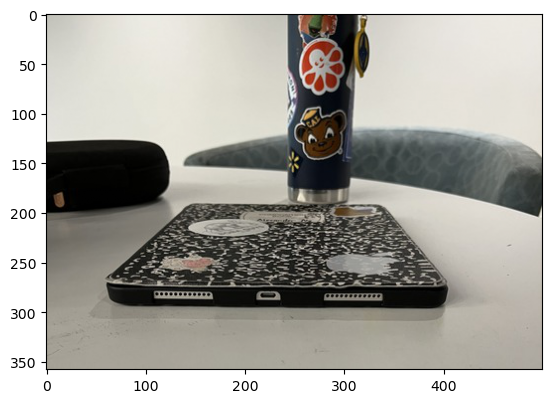

In [7]:
keyb = skio.imread("data/ipad.jpg")
keyb = sk.img_as_float(keyb)
plt.imshow(keyb);

In [8]:
with open("data/ipad_ipad.json") as json_data:
    corr = json.load(json_data)
corr.keys()

dict_keys(['im1_name', 'im2_name', 'im1Points', 'im2Points'])

In [9]:
keyb_corners = np.array(corr['im1Points'])
keyb_corners

array([[148, 189],
       [340, 190],
       [406, 276],
       [ 60, 271]])

In [10]:
new_corners = [[100,60], [360,60],[360,300],[100,300]]

In [11]:
H = compute_homography(new_corners, keyb_corners)
H
print(new_corners)
print(keyb_corners)

[[100, 60], [360, 60], [360, 300], [100, 300]]
[[148 189]
 [340 190]
 [406 276]
 [ 60 271]]


(0,0) becomes (674,1226)
(0,357) becomes (116,395)
(499,357) becomes (375,386)
(499,0) becomes (-151,1286)
new height 825
new width 1286


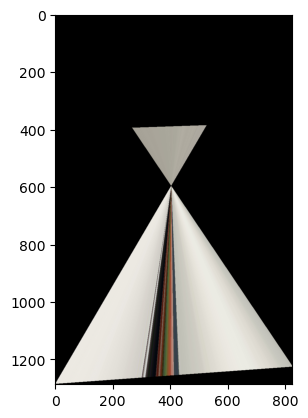

In [12]:
warped = warp_image(keyb, H)
plt.imshow(warped); # height, width

In [13]:
plt.imsave('out/keyboard_rect_crop.jpg', warped[600:,600:])

In [14]:
bww = skio.imread("data/bww.jpg")
bww = sk.img_as_float(bww)
plt.imshow(bww);

FileNotFoundError: No such file: '/Users/naycal/PycharmProjects/imageWrapping&Mosaicing/data/bww.jpg'

In [ ]:
with open("data/bww_bww.json") as json_data:
    corr = json.load(json_data)
corr.keys()

: 

In [ ]:
bww_corners = np.array(corr['im1Points'])
bww_corners

: 

In [ ]:
def rectify(im_path, corr_path):
    im = skio.imread(im_path)
    im = sk.img_as_float(im)
    h, w, _ = im.shape
    
    with open(corr_path) as json_data:
        corr = json.load(json_data)
    corners = np.array(corr['im1Points'])
    new_corners = [[100,100], [100,h-100], [w-100,100], [w-100,h-100]]
    
    H = compute_homography(new_corners, corners)
    return warp_image(im, H)

: 

In [ ]:
bww_warped = rectify('data/bww.jpg', 'data/bww_bww.json')
plt.imshow(bww_warped[:800,:]); # width, height

: 

In [ ]:
plt.imsave('out/bww_rect_crop.jpg', bww_warped[:800,:])

: 

## Blend images into a mosaic

In [ ]:
glade_left = skio.imread('data/glade_left.jpg')
glade_left = sk.img_as_float(glade_left)
plt.imshow(glade_left);

: 

In [ ]:
glade_center = skio.imread('data/glade_center.jpg')
glade_center = sk.img_as_float(glade_center)
plt.imshow(glade_center)

: 

In [ ]:
with open('data/glade_left_center.json') as json_data:
    corr = json.load(json_data)
left_corr = np.array(corr['im1Points'][:7])
center_corr = np.array(corr['im2Points'][:7])

H = compute_homography(left_corr, center_corr)
warped = warp_image(glade_center, H)
plt.imshow(warped)

: 

In [ ]:
warped.shape

: 

In [ ]:
glade_left.shape

: 

In [ ]:
glade_center_warped = warped

: 

In [ ]:
glade_left_padded = np.pad(glade_left, ((298,770-298), (0, 1628), (0,0)))
plt.imshow(0.5 * (glade_left_padded + glade_center_warped))

: 

In [ ]:
def overlap(left, right):
    left_mask = np.where(left != 0, 1., 0.)
    right_mask = np.where(right != 0, 1., 0.)
    combined = left_mask + right_mask
    overlap_mask = np.where(combined != 2, 0., 1.)
    non_overlap = 1 - overlap_mask
    
    nonzeros = np.nonzero(overlap_mask)[1]
    small, big = np.min(nonzeros), np.max(nonzeros)
    grad_vals = np.linspace(0, 1, big - small)
    grad_format = np.transpose(np.vstack((grad_vals, grad_vals, grad_vals)))
    grad = np.ones_like(overlap_mask)
    grad[:, small:big, :] = grad_format

    left_grad = (1 - grad) * overlap_mask
    right_grad = (grad) * overlap_mask

    return left * (non_overlap + left_grad) + right * (non_overlap + right_grad)

: 

In [ ]:
glade_blend = overlap(glade_left_padded, glade_center_warped)
plt.imshow(glade_blend);

: 

In [ ]:
plt.imsave('out/glade_left_padded.jpg', glade_left_padded)
plt.imsave('out/glade_center_warped.jpg', glade_center_warped)
plt.imsave('out/glade_unblended.jpg', 0.5 * (glade_left_padded + glade_center_warped))
plt.imsave('out/glade_blend.jpg', glade_blend)

: 

In [ ]:
apt_left = skio.imread('data/apt_left.jpg')
apt_left = sk.img_as_float(apt_left)

: 

In [ ]:
def transform(im1_path, im2_path, corr_path):
    im1 = skio.imread(im1_path)
    im1 = sk.img_as_float(im1)
    plt.figure()
    plt.imshow(im1)b
    
    im2 = skio.imread(im2_path)
    im2 = sk.img_as_float(im2)
    plt.figure()
    plt.imshow(im2)
    
    with open(corr_path) as json_data:
        corr = json.load(json_data)
    left_corr = np.array(corr['im1Points'])
    right_corr = np.array(corr['im2Points'])

    H = compute_homography(left_corr, right_corr)
    return warp_image(im2, H)

: 

In [ ]:
apt_right_warp = transform('data/apt_left.jpg', 'data/apt_right.jpg', 'data/apt_left_right.json')
plt.imshow(apt_right_warp)

: 

In [ ]:
apt_left.shape

: 

In [ ]:
apt_right_warp.shape

: 

In [ ]:
apt_left_padded = np.pad(apt_left, ((498,2318-1286-498), (0,4501-2285), (0,0)))
apt_left_padded.shape

: 

In [ ]:
apt_blend = overlap(apt_left_padded, apt_right_warp)
plt.imshow(apt_blend);

: 

In [ ]:
plt.imsave('out/apt_left_padded.jpg', apt_left_padded)
plt.imsave('out/apt_right_warp.jpg', apt_right_warp)
plt.imsave('out/apt_unblended.jpg', 0.5 * (apt_left_padded + apt_right_warp))
plt.imsave('out/apt_blend.jpg', apt_blend)

: 

In [ ]:
backyard_left = skio.imread('data/backyard_left.jpg')
backyard_left = sk.img_as_float(backyard_left)

: 

In [ ]:
backyard_right_warp = transform('data/backyard_left.jpg', 'data/backyard_right.jpg', 'data/backyard_left_right.json')
plt.imshow(backyard_right_warp)

: 

In [ ]:
backyard_left.shape

: 

In [ ]:
backyard_right_warp.shape

: 

In [ ]:
backyard_left_pad = np.pad(backyard_left, ((415,2538-1286-415),(0,4919-2285),(0,0)))
backyard_left_pad.shape

: 

In [ ]:
backyard_blend = overlap(backyard_left_pad, backyard_right_warp)
plt.imshow(backyard_blend);

: 

In [ ]:
plt.imsave('out/backyard_left_padded.jpg', backyard_left_pad)
plt.imsave('out/backyard_right_warp.jpg', backyard_right_warp)
plt.imsave('out/backyard_unblended.jpg', 0.5 * (backyard_left_pad + backyard_right_warp))
plt.imsave('out/backyard_blend.jpg', backyard_blend)

: 